In [2]:
Kelompok 8

In [3]:
import os
import glob
import cv2
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [4]:
# Training Data

In [5]:
train_path="jeruk/train"

In [6]:
train_labels=os.listdir(train_path)

In [7]:
train_labels.sort()
print('Class: ', train_labels)

Class:  ['blackspot', 'canker', 'fresh', 'grenning']


In [8]:
le=preprocessing.LabelEncoder()
le.fit(train_labels)

LabelEncoder()

In [9]:
ResizeImage=tuple((224,224))
X=[]
y=[]
for label in train_labels:
    dir=os.path.join(train_path, label)
    
    for file in glob.glob(dir + "/*.jpg") + glob.glob(dir + "/*.png"):
        im=cv2.imread(file)
        im=cv2.resize(im,ResizeImage,interpolation=cv2.INTER_AREA)
        im=cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
        X.append(im)
        y.append(label)
    print("[status] telah selesai baca image untuk folder:{}".format(label))
        
X=np.array(X)
y=np.array(le.transform(y))
print("[status] telah selesai baca image untuk seluruh isi folder train")

[status] telah selesai baca image untuk folder:blackspot
[status] telah selesai baca image untuk folder:canker
[status] telah selesai baca image untuk folder:fresh
[status] telah selesai baca image untuk folder:grenning
[status] telah selesai baca image untuk seluruh isi folder train


In [10]:
X.shape

(1164, 224, 224, 3)

In [11]:
y.shape

(1164,)

In [12]:
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
x_train.shape

(931, 224, 224, 3)

In [14]:
len(x_train)

931

In [15]:
x_val.shape

(233, 224, 224, 3)

In [16]:
y

array([0, 0, 0, ..., 3, 3, 3])

In [17]:
# rescale [0,255] --> [0,1]
x_train=x_train.astype('float32')/255
x_val=x_val.astype('float32')/255

In [18]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# One-hot encode the labels
num_classes = len(np.unique(y_train))
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)

# Print hasil (opsional)
#print(num_classes)
#print(y_train)
#print(y_val)


In [19]:
# break training set into training and validation sets
# (x_train,x_validation)=x_train[len(x_test):], x_train[:len(x_test)]
# (y_train,y_validation)=y_train[len(x_test):], y_train[:len(x_test)]

In [20]:
#print number of training, validation and test images
print(x_train.shape[0], 'train image samples')
#print(x_test.shape[0], 'test image samples')
print(x_val.shape[0], 'validaton image samples')

931 train image samples
233 validaton image samples


# Define Deep Learning Model Architecture

In [21]:
from tensorflow.keras.applications import NASNetMobile

base_model = NASNetMobile(weights = "imagenet", include_top=False, input_shape = (224,224, 3))
base_model.summary()

Model: "NASNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv1 (Conv2D)           │ (None, 111, 111, 32)      │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn1 (BatchNormalization) │ (None, 111, 111, 32)      │             128 │ stem_conv1[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 111, 111, 32)      │               0 │ stem_bn1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reduction_conv_1_stem_1       │ (None, 111, 111, 11)      │             352 │ activation[0][0]           │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reduction_bn_1_stem_1         │ (None, 111, 111, 11)      │              44 │ reduction_conv_1_stem_1[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 111, 111, 11)      │               0 │ reduction_bn_1_stem_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_3 (Activation)     │ (None, 111, 111, 32)      │               0 │ stem_bn1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv_1_pad_reducti… │ (None, 115, 115, 11)      │               0 │ activation_1[0][0]         │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv_1_pad_reducti… │ (None, 117, 117, 32)      │               0 │ activation_3[0][0]         │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv_1_reduction_l… │ (None, 56, 56, 11)        │             396 │ separable_conv_1_pad_redu… │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv_1_reduction_r… │ (None, 56, 56, 11)        │           1,920 │ separable_conv_1_pad_redu… │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv_1_bn_reductio… │ (None, 56, 56, 11)        │              44 │ separable_conv_1_reductio… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv_1_bn_reductio… │ (None, 56, 56, 11)        │              4

 Total params: 4,269,716 (16.29 MB)

 Trainable params: 4,232,978 (16.15 MB)

 Non-trainable params: 36,738 (143.51 KB)

In [22]:
for layer in base_model.layers:
    layer.trainable = False
    
base_model.summary()

Model: "NASNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv1 (Conv2D)           │ (None, 111, 111, 32)      │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn1 (BatchNormalization) │ (None, 111, 111, 32)      │             128 │ stem_conv1[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 111, 111, 32)      │               0 │ stem_bn1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reduction_conv_1_stem_1       │ (None, 111, 111, 11)      │             352 │ activation[0][0]           │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reduction_bn_1_stem_1         │ (None, 111, 111, 11)      │              44 │ reduction_conv_1_stem_1[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 111, 111, 11)      │               0 │ reduction_bn_1_stem_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_3 (Activation)     │ (None, 111, 111, 32)      │               0 │ stem_bn1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv_1_pad_reducti… │ (None, 115, 115, 11)      │               0 │ activation_1[0][0]         │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv_1_pad_reducti… │ (None, 117, 117, 32)      │               0 │ activation_3[0][0]         │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv_1_reduction_l… │ (None, 56, 56, 11)        │             396 │ separable_conv_1_pad_redu… │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv_1_reduction_r… │ (None, 56, 56, 11)        │           1,920 │ separable_conv_1_pad_redu… │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv_1_bn_reductio… │ (None, 56, 56, 11)        │              44 │ separable_conv_1_reductio… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv_1_bn_reductio… │ (None, 56, 56, 11)        │              4

 Total params: 4,269,716 (16.29 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,269,716 (16.29 MB)

In [23]:
from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.models import Model

# use “get_layer” method to save the last layer of the network
# save the output of the last layer to be the input of the next layer
last_layer = base_model.get_layer('activation_187')
last_output = last_layer.output

# flatten the classifier input which is output of the last layer of Nasnet model
x = Flatten()(last_output)

# add 2 FC layers, each has 4096 units and relu activation 
x = Dense(64, activation='relu', name='FC_2')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# add our new softmax layer with 3 hidden units
x = Dense(num_classes, activation='softmax', name='softmax')(x)

# instantiate a new_model using keras’s Model class
new_model = Model(inputs=base_model.input, outputs=x)

# print the new_model summary
new_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv1 (Conv2D)           │ (None, 111, 111, 32)      │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn1 (BatchNormalization) │ (None, 111, 111, 32)      │             128 │ stem_conv1[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 111, 111, 32)      │               0 │ stem_bn1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reduction_conv_1_stem_1       │ (None, 111, 111, 11)      │             352 │ activation[0][0]           │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reduction_bn_1_stem_1         │ (None, 111, 111, 11)      │              44 │ reduction_conv_1_stem_1[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 111, 111, 11)      │               0 │ reduction_bn_1_stem_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_3 (Activation)     │ (None, 111, 111, 32)      │               0 │ stem_bn1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv_1_pad_reducti… │ (None, 115, 115, 11)      │               0 │ activation_1[0][0]         │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv_1_pad_reducti… │ (None, 117, 117, 32)      │               0 │ activation_3[0][0]         │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv_1_reduction_l… │ (None, 56, 56, 11)        │             396 │ separable_conv_1_pad_redu… │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv_1_reduction_r… │ (None, 56, 56, 11)        │           1,920 │ separable_conv_1_pad_redu… │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv_1_bn_reductio… │ (None, 56, 56, 11)        │              44 │ separable_conv_1_reductio… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv_1_bn_reductio… │ (None, 56, 56, 11)        │              4

 Total params: 7,581,912 (28.92 MB)

 Trainable params: 3,312,068 (12.63 MB)

 Non-trainable params: 4,269,844 (16.29 MB)

# Compile the model

In [24]:
new_model.compile(loss='categorical_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])

# Train the model

In [25]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical

# # Dummy data (ganti dengan data Anda sendiri)
# x_train = np.random.rand(100, 20)  # 100 samples, 20 features
# x_val = np.random.rand(20, 20)  # 20 samples, 20 features
# y_train = np.random.randint(0, 3, 100)  # 100 labels untuk 3 kelas
# y_val = np.random.randint(0, 3, 20)  # 20 labels untuk 3 kelas

# # One-hot encode the labels
# num_classes = len(np.unique(y_train))
# y_train = to_categorical(y_train, num_classes)
# y_val = to_categorical(y_val, num_classes)

# # Check shapes
# print("Shape x_train:", x_train.shape)
# print("Shape y_train after one-hot encoding:", y_train.shape)
# print("Shape x_val:", x_val.shape)
# print("Shape y_val after one-hot encoding:", y_val.shape)

# # Model
# new_model = Sequential()
# new_model.add(Dense(64, input_dim=20, activation='relu'))  # Adjust input_dim sesuai dengan fitur input Anda
# new_model.add(Dense(num_classes, activation='softmax'))

# new_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Checkpointer
checkpointer = ModelCheckpoint(filepath='model.NASnet.keras', verbose=1, save_best_only=True)

# Train the model
hist = new_model.fit(x_train, y_train, batch_size=32, epochs=20, validation_data=(x_val, y_val), callbacks=[checkpointer], verbose=2, shuffle=True)

# Print training history keys (opsional)
print(hist.history.keys())


Epoch 1/20

Epoch 1: val_loss improved from inf to 0.37270, saving model to model.NASnet.keras
30/30 - 69s - 2s/step - accuracy: 0.8808 - loss: 0.3818 - val_accuracy: 0.9056 - val_loss: 0.3727
Epoch 2/20

Epoch 2: val_loss improved from 0.37270 to 0.17109, saving model to model.NASnet.keras
30/30 - 32s - 1s/step - accuracy: 0.9517 - loss: 0.1517 - val_accuracy: 0.9356 - val_loss: 0.1711
Epoch 3/20

Epoch 3: val_loss improved from 0.17109 to 0.10748, saving model to model.NASnet.keras
30/30 - 29s - 950ms/step - accuracy: 0.9656 - loss: 0.1284 - val_accuracy: 0.9657 - val_loss: 0.1075
Epoch 4/20

Epoch 4: val_loss improved from 0.10748 to 0.09664, saving model to model.NASnet.keras
30/30 - 25s - 845ms/step - accuracy: 0.9678 - loss: 0.1071 - val_accuracy: 0.9700 - val_loss: 0.0966
Epoch 5/20

Epoch 5: val_loss did not improve from 0.09664
30/30 - 26s - 870ms/step - accuracy: 0.9753 - loss: 0.0938 - val_accuracy: 0.9571 - val_loss: 0.1022
Epoch 6/20

Epoch 6: val_loss improved from 0.0966

In [26]:
print(hist.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


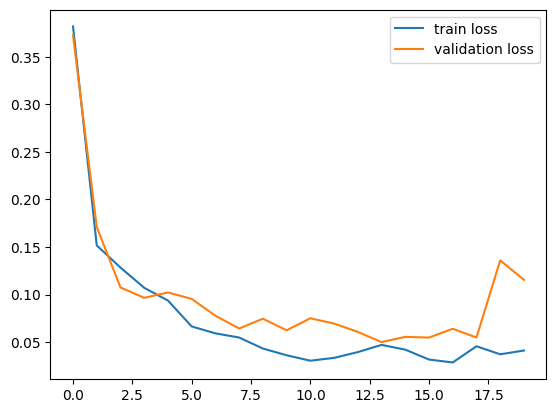

<Figure size 640x480 with 0 Axes>

In [27]:
import matplotlib.pyplot as plt

# Loss
plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='validation loss')
plt.legend()
plt.show()
plt.savefig('LossValidation_loss')

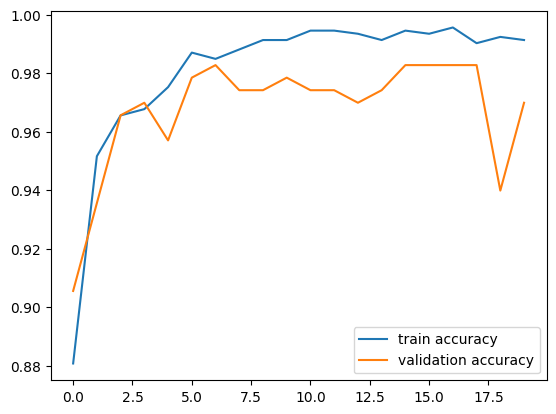

<Figure size 640x480 with 0 Axes>

In [28]:
# accuracy
plt.plot(hist.history['accuracy'], label='train accuracy')
plt.plot(hist.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()
plt.savefig('AccValidation_accuracy')

# Testing Data

In [29]:
test_path="jeruk/test"

In [30]:
test_labels=os.listdir(test_path)

In [31]:
test_labels.sort()
print('Class: ', test_labels)

Class:  ['blackspot', 'canker', 'fresh', 'grenning']


In [32]:
le=preprocessing.LabelEncoder()
le.fit(test_labels)

LabelEncoder()

In [33]:
ResizeImage=tuple((224,224))
X_test=[]
y_test=[]
for label in test_labels:
    dir=os.path.join(test_path, label)
    
    for file in glob.glob(dir + "/*.jpg") + glob.glob(dir + "/*.png"):
        im=cv2.imread(file)
        im=cv2.resize(im,ResizeImage,interpolation=cv2.INTER_AREA)
        im=cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
        X_test.append(im)
        y_test.append(label)
    print("[status] telah selesai baca image untuk folder:{}".format(label))
        
X_test=np.array(X_test)
y_test=np.array(le.transform(y_test))
print("[status] telah selesai baca image untuk seluruh isi folder test")

[status] telah selesai baca image untuk folder:blackspot
[status] telah selesai baca image untuk folder:canker
[status] telah selesai baca image untuk folder:fresh
[status] telah selesai baca image untuk folder:grenning
[status] telah selesai baca image untuk seluruh isi folder test


In [34]:
X_test.shape

(626, 224, 224, 3)

In [35]:
y_test.shape

(626,)

In [36]:
# rescale [0,255] --> [0,1]
#x_train=x_train.astype('float32')/255
X_test=X_test.astype('float32')/255

In [37]:
#one-hot encode the labels
import tensorflow.keras as keras
num_classes=len(np.unique(y_test))
#y_train=keras.utils.np_utils.to_categorical(y_train,num_classes)
# y_test=keras.utils.np_utils.to_categorical(y_test,num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Load the model with the Best Validation Accuracy

In [38]:
new_model.load_weights('model.NASnet.keras')

# evaluate and print test accuracy

In [39]:
score=new_model.evaluate(X_test,y_test,verbose=1)
print('\n', 'Test accuracy: ', score[1])

20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 713ms/step - accuracy: 0.9949 - loss: 0.0223

 Test accuracy:  0.995207667350769


In [40]:
# get prediction on the test set
y_predict=new_model.predict(X_test)

20/20 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step 


In [41]:
# define test labels 
test_labels

['blackspot', 'canker', 'fresh', 'grenning']

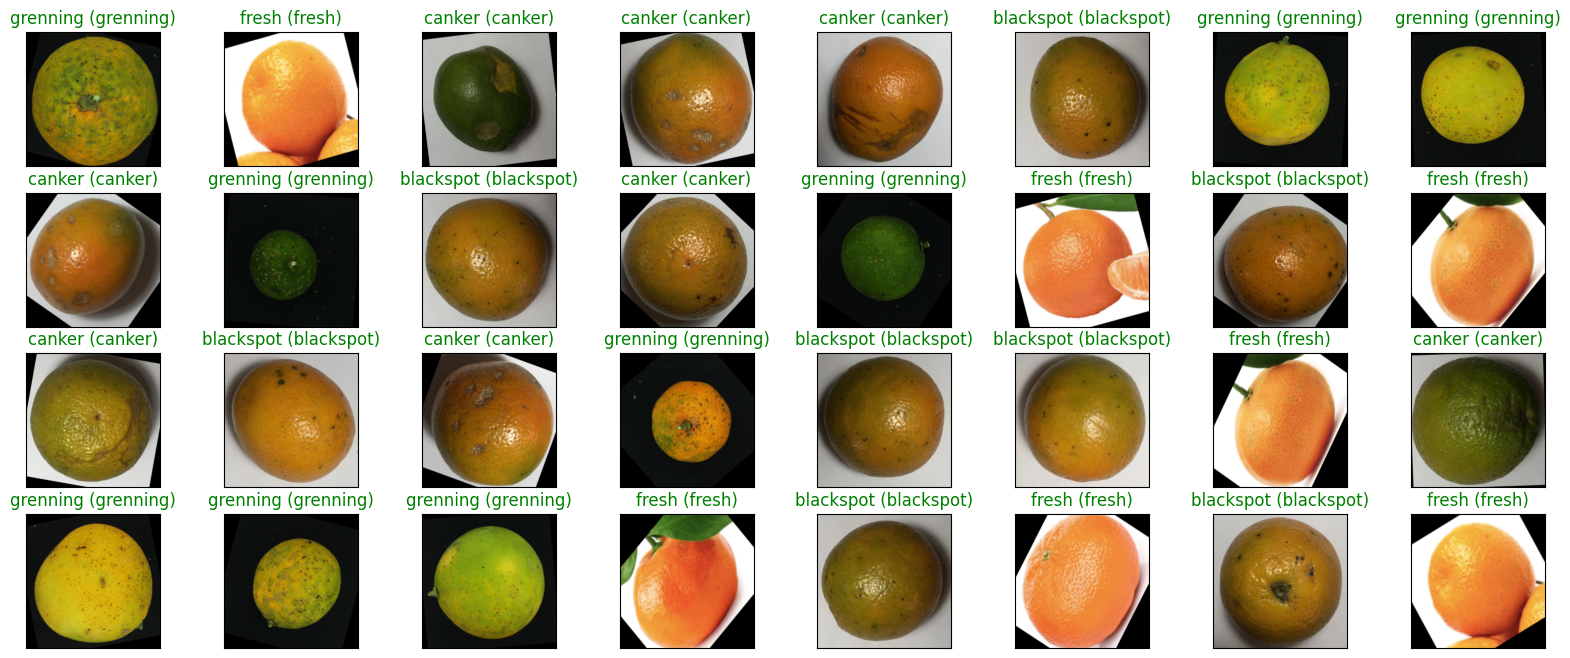

In [42]:
fig=plt.figure(figsize=(20,8))
for i, idx in enumerate(np.random.choice(X_test.shape[0],size=32,replace=False)):
    ax = fig.add_subplot(4, 8 , i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[idx]))
    pred_idx = np.argmax(y_predict[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(train_labels[pred_idx], train_labels[true_idx]), color=("green" if pred_idx == true_idx else "red"))
    

In [43]:
y_pred=np.argmax(y_predict, axis=1)

In [44]:
y_true=np.argmax(y_test, axis=1)

In [45]:
from sklearn.metrics import confusion_matrix

matrix=confusion_matrix(y_true, y_pred)
print(matrix)

[[138   0   0   0]
 [  3 145   0   0]
 [  0   0 164   0]
 [  0   0   0 176]]


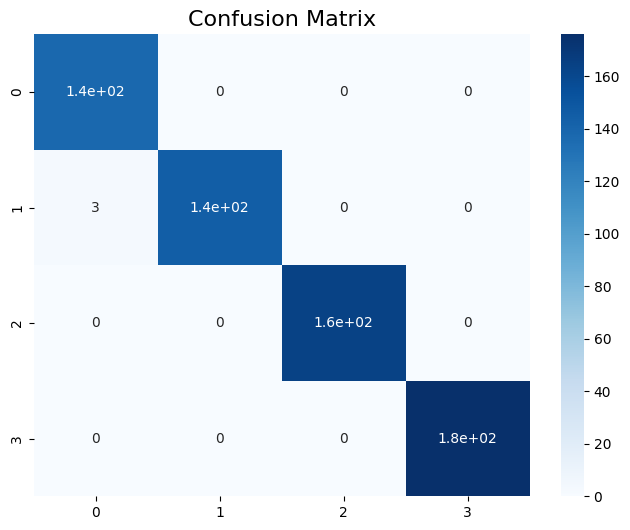

In [46]:
import seaborn as sns

#cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix', size=16)
sns.heatmap(matrix, annot=True, cmap='Blues');

In [47]:
from sklearn.metrics import classification_report
target_names = ['blackspot', 'canker','fresh','greening']

print('============================== Report ===================================')
print(classification_report(y_true,y_pred, target_names=target_names))

print('========================== Confution Matrix =============================')
matrix=confusion_matrix(y_true, y_pred)
print(matrix)


print("============================ Cohen Kappa ================================")
from sklearn.metrics import cohen_kappa_score
print('Kappa score: ',cohen_kappa_score(y_true,y_pred))


============================== Report ===================================
              precision    recall  f1-score   support

   blackspot       0.98      1.00      0.99       138
      canker       1.00      0.98      0.99       148
       fresh       1.00      1.00      1.00       164
    greening       1.00      1.00      1.00       176

    accuracy                           1.00       626
   macro avg       0.99      0.99      0.99       626
weighted avg       1.00      1.00      1.00       626

========================== Confution Matrix =============================
[[138   0   0   0]
 [  3 145   0   0]
 [  0   0 164   0]
 [  0   0   0 176]]
============================ Cohen Kappa ================================
Kappa score:  0.9935923244371959
